# Xuất Mô Hình PyTorch Sang ONNX

Notebook này hướng dẫn bạn cách xuất một mô hình PyTorch sang ONNX và kiểm tra nó bằng ONNX Runtime.

## 1. Cài đặt các thư viện cần thiết
Đầu tiên, bạn cần cài đặt các thư viện **onnx**, **onnxscript**, và **onnxruntime**:

In [1]:
!pip install onnx onnxscript onnxruntime

## 2. Xây dựng mô hình phân loại ảnh bằng PyTorch
Chúng ta sẽ tạo một mô hình CNN đơn giản sử dụng `torch.nn`: 

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## 3. Xuất mô hình PyTorch sang ONNX
Tạo một mô hình PyTorch và một tensor input ngẫu nhiên, sau đó xuất sang ONNX:

In [3]:

torch_model = MyModel()
torch_input = torch.randn(1, 1, 32, 32)  # Batch size = 1, Channel = 1, 32x32 image

# Xuất mô hình sang ONNX
onnx_program = torch.onnx.dynamo_export(torch_model, torch_input)


/opt/anaconda3/envs/env_onnx/lib/python3.10/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/opt/anaconda3/envs/env_onnx/lib/python3.10/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/opt/anaconda3/envs/env_onnx/lib/python3.10/site-packages/torch/onnx/_internal/_exporter_legacy.py:101: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(
/opt/anaconda3/envs/env_onnx/lib/python3.10/site-packages/torch/onnx/_internal/fx/onnxfunction_dispatcher.py:503: FutureWarning: 'onnxscr

**Lưu ý:** TorchDynamo chỉ hỗ trợ **opset version 18**.

## 4. Lưu mô hình ONNX ra file
Sau khi xuất thành công, ta có thể lưu mô hình vào file `.onnx`: 

In [4]:

onnx_program.save("my_image_classifier.onnx")


## 5. Kiểm tra mô hình ONNX
Để kiểm tra mô hình đã lưu có hợp lệ không, ta có thể tải lại và chạy `onnx.checker`: 

In [5]:

import onnx

onnx_model = onnx.load("my_image_classifier.onnx")
onnx.checker.check_model(onnx_model)
print("Mô hình ONNX hợp lệ.")


Mô hình ONNX hợp lệ.


## 6. Xem mô hình ONNX bằng Netron
Bạn có thể xem mô hình ONNX bằng Netron thông qua web:

🔗 **Mở link:** [https://netron.app/](https://netron.app/)

Kéo và thả file **my_image_classifier.onnx** vào Netron để hiển thị kiến trúc mạng.

## 7. Chạy mô hình ONNX bằng ONNX Runtime
Tạo **Inference Session** và thực thi mô hình ONNX với ONNX Runtime:

In [6]:

import onnxruntime

onnx_input = [torch_input]
ort_session = onnxruntime.InferenceSession("my_image_classifier.onnx", providers=['CPUExecutionProvider'])
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

print(f"Đầu ra của ONNX Runtime: {onnxruntime_outputs}")


Đầu ra của ONNX Runtime: [[ 0.0373623  -0.00121417  0.00544075  0.05627235 -0.11026684 -0.09599696
   0.00558871 -0.01794788  0.06999215 -0.10306659]]


## 8. So sánh kết quả giữa PyTorch và ONNX Runtime
Chạy mô hình PyTorch với cùng input và so sánh đầu ra:

In [7]:
torch_outputs = torch_model(torch_input)
assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnx_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnx_output))

print("Kết quả của PyTorch và ONNX Runtime khớp nhau!")

Kết quả của PyTorch và ONNX Runtime khớp nhau!


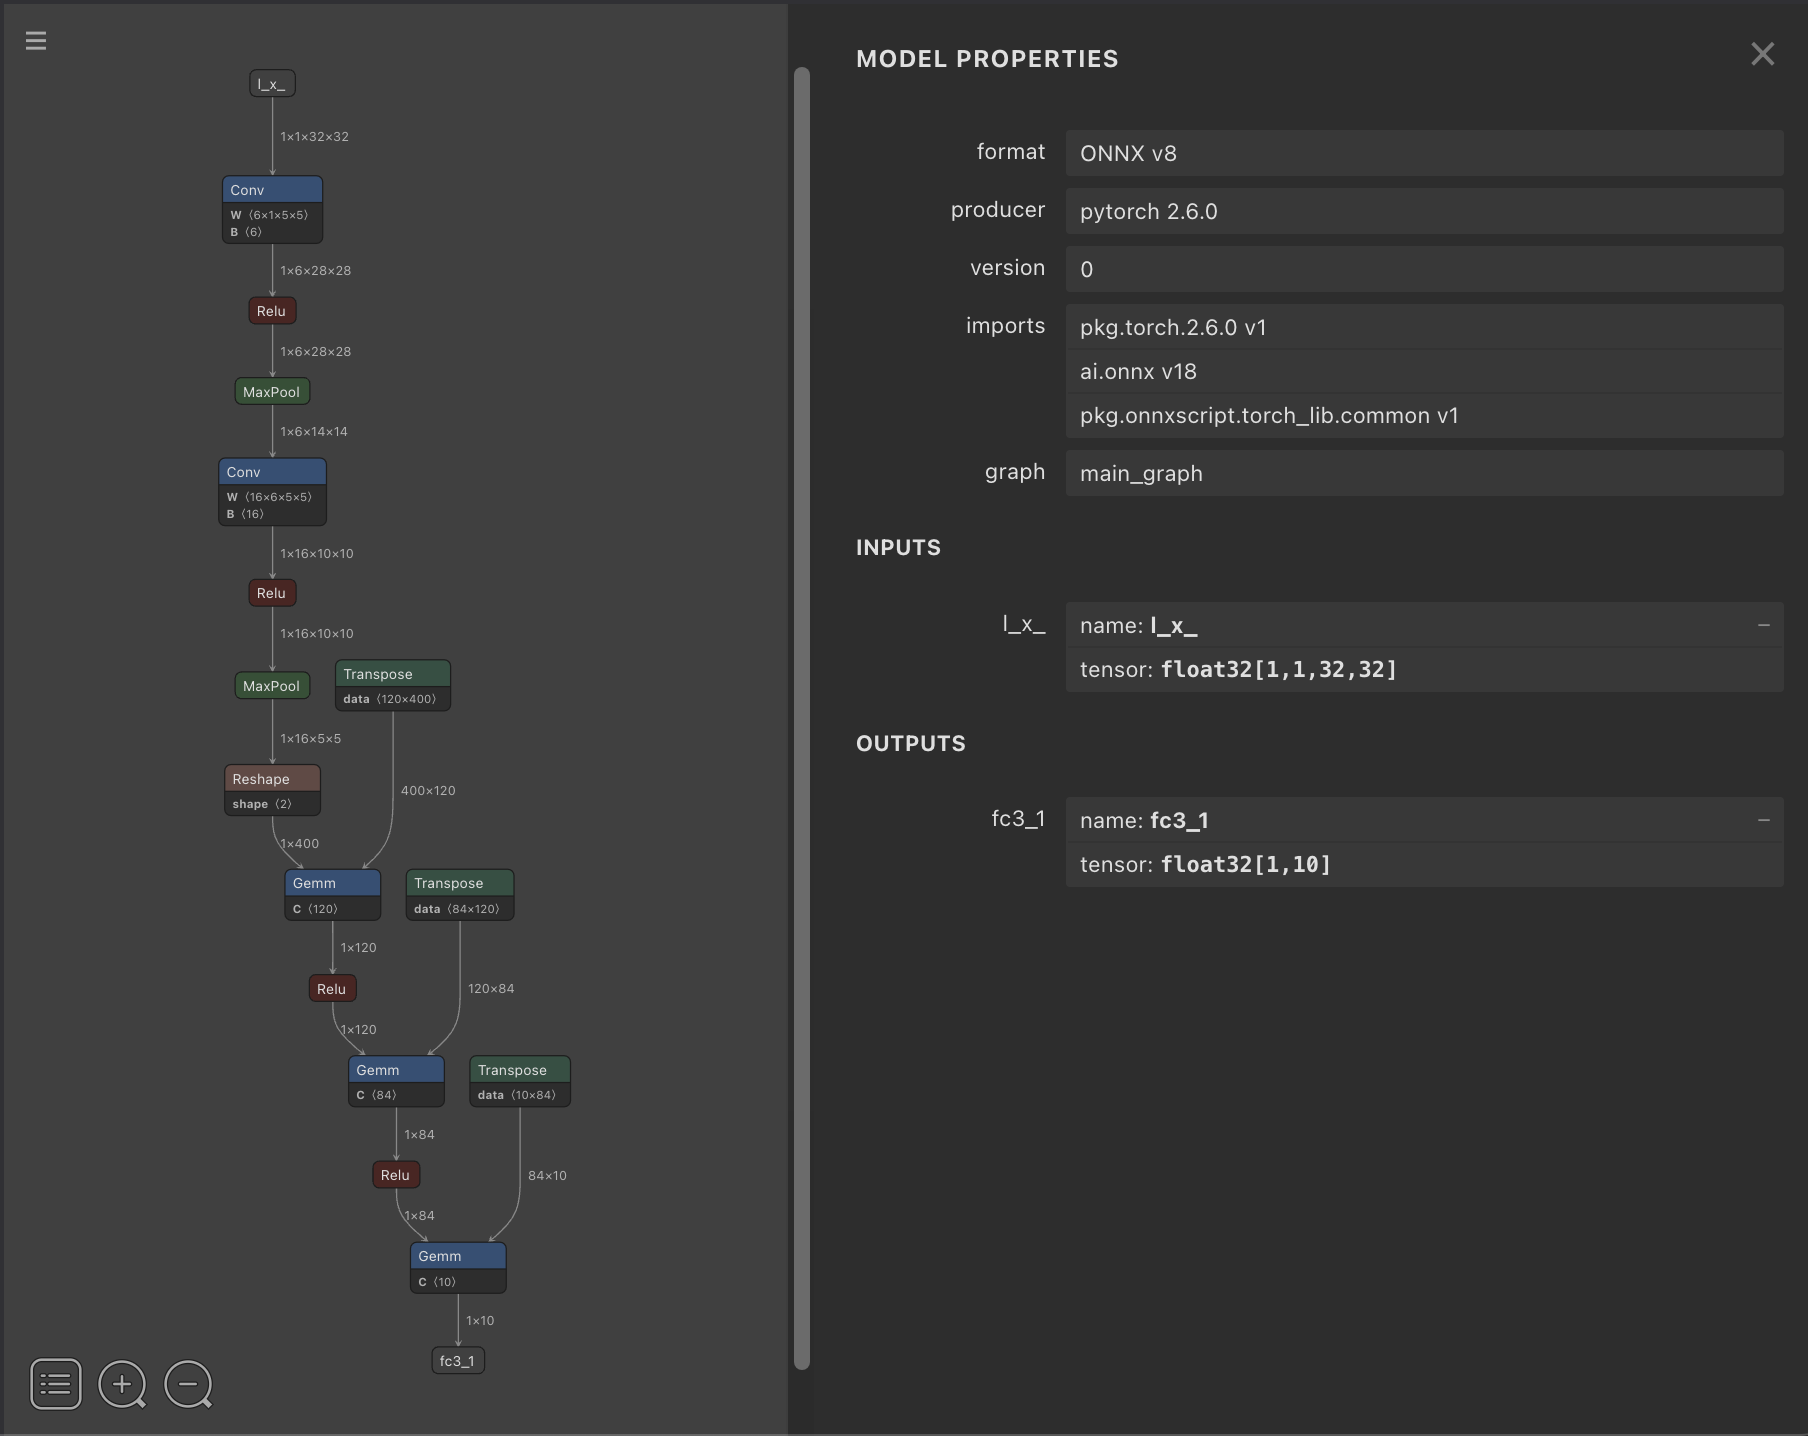

In [8]:
import IPython.display as display
image_path = "pic.jpg"
display.display(display.Image(image_path))